<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 3
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

#GitHub

Let's clone the repo with the dataset

In [44]:
!git clone https://github.com/dkdk22/DL_Ass3
import sys
# Add the repository to the path
sys.path.insert(1, '/content/DL_Ass3/')

fatal: destination path 'DL_Ass3' already exists and is not an empty directory.


# Setup

Firstly let's setup the workspace

## Pip Installs

In [96]:
# Install the latest version of TensorFlow, which includes Keras (tf.keras)
#!pip install tensorflow --upgrade
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


## Packages

Let's import all the necessary functions and packages

In [97]:
from dl_utils import plot_history
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import nltk
from nltk.corpus import stopwords
import keras_tuner as kt
from keras import backend as backend
from keras import layers
from keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
    UpSampling2D
)
from keras.optimizers import SGD, Adam

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import json
import zipfile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import gdown
import zipfile
import os
from keras import Model, ops
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.ensemble import GradientBoostingClassifier
from nltk.stem import PorterStemmer
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.applications as app
from keras.layers import LSTM, Dense, Embedding, Input, GRU, Bidirectional
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import minmax_scale
import pickle
#from sentence_transformers import SentenceTransformer
from imblearn.keras import BalancedBatchGenerator
from sklearn.decomposition import PCA
import tensorflow.data as tf_data

import warnings
warnings.filterwarnings('ignore')

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
module 'keras._tf_keras.keras' has no attribute '__internal__'

#Global variables

In [67]:
SEED = 42
BATCH_SIZE = 256
TRAIN_BASELINE = False
SEARCH_PARAMETERS = True
TRAIN_MODEL = True

# Load data

Load the dataset

In [68]:
zip_file_path = 'DL_Ass3/dataset/review_553850.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: #Extract the file
    zip_ref.extractall()

with open('review_553850.json', 'r') as json_file: # Open the json file
    data = json.load(json_file)

X = []
y = []

for id, review in data["reviews"].items():
    review_text = review["review"]
    funny_votes = review["votes_funny"]
    if review_text:  # Check if review_text is not empty
        X.append(review_text)
        y.append(funny_votes)

X = np.array(X)
y = np.array(y)

##Data preprocessing

Now let's look at the dataset for possible imbalances

In [69]:
def check_for_imbalance(X, y):
  #Assuming y is a numpy array containing labels
  #and X is a numpy array containing features
  #Indices where y equals 0
  indices_y0 = np.where(y == 0)[0]
  size_X_y0 = len(indices_y0)

  #Indices where y equals 1
  indices_y1 = np.where(y == 1)[0]
  size_X_y1 = len(indices_y1)

  print("Size of X when y = 0:", size_X_y0)
  print("Size of X when y = 1:", size_X_y1)

In [70]:
check_for_imbalance(X, y)

Size of X when y = 0: 182691
Size of X when y = 1: 5118


Seeing that the dataset is imbalanced, let's define a function to balance out the classes, such that we have an equal number of samples for each class in the dataset.

In [71]:
def balance_classes(X, y):
    # Find indices of examples for each class
    indices_class_0 = np.where(y == 0)[0]
    indices_class_1 = np.where(y == 1)[0]

    # Calculate the number of examples in each class
    num_class_0 = len(indices_class_0)
    num_class_1 = len(indices_class_1)

    # Randomly select a subset of examples from class 0 to match the number of examples in class 1
    if num_class_0 > num_class_1:
        # Randomly shuffle indices of class 0 examples
        np.random.shuffle(indices_class_0)
        # Keep only enough examples from class 0 to match the number of examples in class 1
        indices_class_0 = indices_class_0[:num_class_1]
    elif num_class_1 > num_class_0:
        # Randomly shuffle indices of class 1 examples
        np.random.shuffle(indices_class_1)
        # Keep only enough examples from class 1 to match the number of examples in class 0
        indices_class_1 = indices_class_1[:num_class_0]

    # Combine the balanced indices
    balanced_indices = np.concatenate([indices_class_0, indices_class_1])

    # Shuffle the combined indices
    np.random.shuffle(balanced_indices)

    # Return the balanced subset of data
    return X[balanced_indices], y[balanced_indices]


Balance the dataset if requested

In [72]:
if BALANCE_DATASET:
  X, y = balance_classes(X, y)
print(X.shape)


# Calculate lengths of all sequences
sequence_lengths = [len(sequence) for sequence in X]

# Calculate the median length
sorted_lengths = sorted(sequence_lengths)
n = len(sorted_lengths)
if n % 2 == 0:
    median_length = (sorted_lengths[n // 2 - 1] + sorted_lengths[n // 2]) / 2
else:
    median_length = sorted_lengths[n // 2]

SEQUENCE_LENGTH = int(median_length)

print("Median length of sequences:", SEQUENCE_LENGTH)

(10236,)
Median length of sequences: 56


We are going to do the same preprocessing as in the other notebook. We are going to eliminate stopwords and also we are going to use steeming, tokenize and pad the sentences.


In [73]:
vectorizer = keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=SEQUENCE_LENGTH
    )
text_ds = tf_data.Dataset.from_tensor_slices(X).batch(BATCH_SIZE)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [74]:
!unzip -q DL_Ass3/embeddings/glove.6B.100d.txt -d DL_Ass3/embeddings/
path_to_glove_file = "DL_Ass3/embeddings/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

[DL_Ass3/embeddings/glove.6B.100d.txt]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
replace DL_Ass3/embeddings/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
Found 400000 word vectors.


In [75]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12454 words (4452 misses)


Delete variables to save memory

#Binary classification problem

We can see that this is a really difficoult task to learn because most of the reviews have 0 funny_votes and some of them have a really high value of funny_votes. That's why we are going to change the approach and convert the problem to a binary classification problem, that should be easier to learn to our model.

## Data conversion

We are going to convert it by fixing an number of funny_votes N, treating a review as funny or not funny depending on whether it has more or fewer votes than N. In our case N is going to be 1 because of the unbalancement of the dataset.

In [76]:
if BALANCE_DATASET:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED, stratify=y_train)

else:
  # Take only 10% of the data otherwise training and evaluation would be too slow.
  _, X_train, _, y_train = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=SEED, stratify=y)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=SEED, stratify=y_train)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED, stratify=y_train)

In [77]:
check_for_imbalance(X_train, y_train)

Size of X when y = 0: 3275
Size of X when y = 1: 3275


In [78]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val = vectorizer(np.array([[s] for s in X_val])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## Models Building

### Baseline Model

In [79]:
baseline_model = GradientBoostingClassifier()

### Our Model

In [80]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

#del embedding_matrix

Define the hypermodel

In [81]:
class HyperModelBuilderBinary(kt.HyperModel):
    def __init__(self, seq_length, loss_function, max_features):
        self.seq_length = int(seq_length)
        self.loss_function = loss_function
        self.max_features = max_features

    def build_lstm_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = LSTM(units=units, #https://keras.io/api/layers/recurrent_layers/lstm/
                       dropout=dropout,
                       recurrent_dropout=dropout #reduce two dropouts
                 )(emb)
        x = Dense(units, activation="relu")(x)
        x = Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=self.loss_function,
                      metrics=["accuracy"])

        model.summary()

        return model

    def build_bidirectional_lstm_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = Bidirectional(LSTM(units=units,
                               dropout=dropout,
                               recurrent_dropout=dropout
                               ))(emb)
        #x = Bidirectional(LSTM(units=units,
        #                       dropout=dropout,
        #                       recurrent_dropout=dropout))(x)
        x = Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=self.loss_function,
                      metrics=["accuracy"])

        model.summary()

        return model


    def build_gru_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = GRU(units=units, #https://keras.io/api/layers/recurrent_layers/lstm/
                       dropout=dropout,
                       recurrent_dropout=dropout #reduce two dropouts
                 )(emb)
        x = Dense(units, activation="relu")(x)
        x = Dropout(dropout)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=self.loss_function,
                      metrics=["accuracy"])

        model.summary()

        return model

    def build_cnn_model(self, dropout, units, learning_rate):

        inputs = keras.Input(shape=(None,), dtype="int32")
        emb = embedding_layer(inputs)
        x = layers.Conv1D(units*3, 5, activation="relu", strides=1, padding="same")(emb)
        x = layers.MaxPooling1D(3)(x)
        x = layers.Conv1D(units*2, 3, activation="relu", strides=1, padding="same")(x)
        x = layers.MaxPooling1D(3)(x)
        x = layers.Conv1D(units, 3, activation="relu", strides=1, padding="same")(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        preds = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, preds)

        model.compile(optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate),
            loss=self.loss_function,
            metrics=["accuracy"])

        model.summary()

        return model

    def build_model(self,hp):
        model_name = hp.Choice('model_name', values=['LSTM', 'GRU', 'CNN', 'BidirectionalLSTM'])
        dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.2)
        units = hp.Int('units', min_value=16, max_value=80, step=16)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        if model_name == 'LSTM':
            return self.build_lstm_model(dropout, units, learning_rate)
        elif model_name == 'BidirectionalLSTM':
            return self.build_bidirectional_lstm_model(dropout, units, learning_rate)
        elif model_name == 'GRU':
            return self.build_gru_model(dropout, units, learning_rate)
        elif model_name == 'CNN':
            return self.build_cnn_model(dropout, units, learning_rate)


    def fit(self, hp, model, *args, **kwargs):
        training_generator = BalancedBatchGenerator(
          X_train, y_train, batch_size=BATCH_SIZE, random_state=SEED, shuffle=True
        )
        return model.fit(training_generator, validation_data=(X_val, y_val))

Define the hypertuner

In [82]:
loss = keras.losses.BinaryCrossentropy(
      from_logits=False,
      label_smoothing=0.0,
      axis=-1,
      reduction="sum_over_batch_size",
      name="binary_crossentropy",
)

# Define hyperparameters for the tuner
hypermodel_builder = HyperModelBuilderBinary(seq_length=SEQUENCE_LENGTH,
                                       loss_function=loss, max_features=10000)

# Initialize tuner
tuner = kt.BayesianOptimization(hypermodel_builder.build_model,
                        objective='val_loss',
                        max_trials=10,
                        executions_per_trial=1, # The documentation says that makes things faster
                        overwrite=True,
                        max_consecutive_failed_trials=5,
                        directory='tuner_results',
                        project_name='classification_tuning')

# Summarize the search space
tuner.search_space_summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,690,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           7,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,698,577 (6.48 MB)

 Trainable params: 1,698,577 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

Search space summary
Default search space size: 4
model_name (Choice)
{'default': 'LSTM', 'conditions': [], 'values': ['LSTM', 'GRU', 'CNN', 'BidirectionalLSTM'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.2, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 80, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Training

## Baseline training

In [83]:
if TRAIN_BASELINE:
  baseline_model.fit(X_train, y_train)
  joblib.dump(baseline_model, '/content/DL_Ass3/models/baseline_model_cla.pkl')
else:
  baseline_model = joblib.load('/content/DL_Ass3/models/baseline_model_cla.pkl')

## Our model's training

### Search
Search the parameters for our model

In [84]:
if SEARCH_PARAMETERS:
  # Early stop to prevent overfitting
  stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
  )

  # Perform hyperparameter search
  tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=BATCH_SIZE, callbacks=[stop_early])
  # Get the best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  # Define the file name where you want to save the hyperparameters
  file_name = "/content/DL_Ass3/parameters/best_hps_cla.json"
  #Save the hp
  with open("/content/DL_Ass3/parameters/best_hps_cla.pkl", "wb") as f:
    pickle.dump(best_hps, f)

Trial 10 Complete [00h 00m 03s]
val_loss: 0.664982259273529

Best val_loss So Far: 0.6616011261940002
Total elapsed time: 00h 01m 06s


### Train
Train our model or load the weights if offline search

{'model_name': 'BidirectionalLSTM', 'dropout': 0.0, 'units': 32, 'learning_rate': 0.001}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,690,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,726,961 (6.59 MB)

 Trainable params: 1,726,961 (6.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5503 - loss: 0.6870 - val_accuracy: 0.5940 - val_loss: 0.6666
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6045 - loss: 0.6627 - val_accuracy: 0.5989 - val_loss: 0.6568
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6221 - loss: 0.6469 - val_accuracy: 0.6239 - val_loss: 0.6529
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6679 - loss: 0.6159 - val_accuracy: 0.6239 - val_loss: 0.6509
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6884 - loss: 0.5949 - val_accuracy: 0.6203 - val_loss: 0.6608
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7231 - loss: 0.5604 - val_accuracy: 0.6136 - val_loss: 0.6802
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7627 - loss: 0.5046 - val_accuracy: 0.6020 - val_loss: 0.7398
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7938 - loss: 0.4594 - val_accuracy: 0.5934 - v

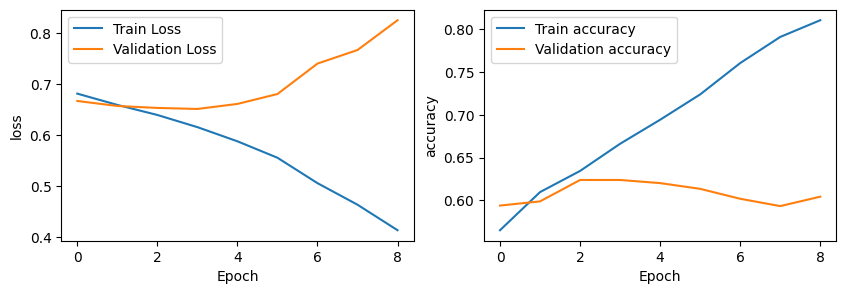

In [85]:
# Read the best parameters
with open("/content/DL_Ass3/parameters/best_hps_cla.pkl", "rb") as f:
  best_hps = pickle.load(f)
  print(best_hps.values)

# Build the model
best_model = tuner.hypermodel.build(best_hps)

if TRAIN_MODEL:
  # Early stop to prevent overfitting
  stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=3,
  )

  # Fit the model
  history = best_model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[stop_early])
  # Save the model
  best_model.save_weights('/content/DL_Ass3/models/best_model_cla.weights.h5')
  plot_history(history)

else:
  best_model.load_weights('/content/DL_Ass3/models/best_model_cla.weights.h5')


# Evaluation

In [86]:
def compute_class_accuracies(X_data, y_data, model):
  # The predicted probabilities for each class
  y_pred_probs = model.predict(X_data)

  # The corresponding predicted labels
  y_pred_labels = np.argmax(y_pred_probs, axis=0)

  # The corresponding true labels
  y_true_labels = np.argmax(y_data, axis=0)

  # Compute confusion matrix
  cm = confusion_matrix(y_true_labels, y_pred_labels)

  # Compute accuracies and weights for each class
  class_accuracies = []
  for class_label in range(len(cm)):
      class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
      class_accuracies.append(class_accuracy)

  # Print the classification report
  print(classification_report(y_true_labels, y_pred_labels))

  return class_accuracies

## Baseline evaluation

In [87]:
y_pred = baseline_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
  # Print the classification report
print(classification_report(y_test, y_pred))

ValueError: X has 56 features, but GradientBoostingClassifier is expecting 1600 features as input.

We can see that the model is only predicting 0

## Our model's evaluation

In [88]:
y_pred = best_model.predict(X_test)
#print(y_pred)
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
y_pred_binary=np.squeeze(y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)
  # Print the classification report
print(classification_report(y_test, y_pred_binary))

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.64208984375
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1024
           1       0.65      0.61      0.63      1024

    accuracy                           0.64      2048
   macro avg       0.64      0.64      0.64      2048
weighted avg       0.64      0.64      0.64      2048

